In [1]:
import numpy as np
import pandas as pd
import xlrd

import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

from sklearn.model_selection import train_test_split

def split(X_, index):
    y_ = [index]*len(X_)
    return train_test_split(X_, y_, test_size=0.40, random_state=42)

import glob

def get_fft_set(file_names):
    fft_set = []
    for files in file_names:
        data = pd.read_csv(files)
        fft_data = fft_from_data_frame(data)
        fft_set = fft_data + fft_set
    return fft_set

def fft_from_data_frame(data_frame):
    fs= 1.14e6
    signal_set = []
    nan_indexes = np.where(np.any(np.isnan(data_frame.values), axis=1))
    data_frame_values = np.delete(data_frame.values, nan_indexes, axis=0)
    for row in data_frame_values:
        fft_data = fft(row, n=row.size)/row.size
        freq = fftfreq(row.size, d=1/fs)
        cut_high_signal = abs(fft_data).copy()
        cut_high_signal[(freq > 50000)] = 0
        cut_high_signal[(freq < 30000)] = 0
        signal_without_0 = list(filter(lambda a: a != 0, cut_high_signal))
        signal_set.append(np.abs(signal_without_0))
    return signal_set

car_side = glob.glob('../data/1mhz_data/result/26_Ford_Black_side/*_overall.csv')
wall = glob.glob('../data/1mhz_data/result/Wall/*_overall.csv')
pillar = glob.glob('../data/1mhz_data/result/Pillar/*_overall.csv')
human = glob.glob('../data/1mhz_data/result/Human/*_overall.csv')

car_side_fft = get_fft_set(car_side)
wall_fft = get_fft_set(wall)
pillar_fft = get_fft_set(pillar)
human_fft = get_fft_set(human)

print("Car: ", len(car_side_fft))
print("Wall: ", len(wall_fft))
print("Pillar: ", len(pillar_fft))
print("Human: ", len(human_fft))

result = len(car_side_fft) + len(wall_fft) + len(pillar_fft) + len(human_fft)
print("Total data: ", result)

Car:  5851
Wall:  5456
Pillar:  5772
Human:  3700
Total data:  20779


In [3]:
human = human_fft
X_Human_train, X_Human_test, y_Human_train, y_Human_test = split(human, 'HUMAN')

Non_Human = car_side_fft + wall_fft + pillar_fft
X_Non_Human_train, X_Non_Human_test, y_Non_Human_train, y_Non_Human_test = split(Non_Human, 'NOT HUMAN')

X_Human_Non_Human_train = X_Human_train + X_Non_Human_train
# X_Human_Non_Human_test = np.nan_to_num(X_Human_test + X_Non_Human_test)
X_Human_Non_Human_test = (X_Human_test + X_Non_Human_test)

y_Human_Non_Human_train = y_Human_train + y_Non_Human_train
y_Human_Non_Human_test = y_Human_test + y_Non_Human_test

# np.nan_to_num(X)

print(np.array(X_Human_train).shape,np.array(X_Human_test).shape, np.array(y_Human_train).shape, np.array(y_Human_test).shape)
# print(np.array(X_Non_Human_train).shape, np.array(X_Non_Human_test).shape, np.array(y_Non_Human_train).shape, np.array(y_Non_Human_test).shape)
# print(len(X_Human_Non_Human_train))
# print(len(X_Human_Non_Human_test))
# print(len(y_Human_Non_Human_train))
# print(len(y_Human_Non_Human_test))


(2220, 36) (1480, 36) (2220,) (1480,)


In [8]:
from sklearn import preprocessing
def custom_normalization(X_set):
    new_X_set = []
    for X in X_set:
        min = np.min(X)
        max = np.max(X)
        value = max - min
        data_set = []
        for data in X:
           data_set.append(((data - min) / value) + 0)
        new_X_set.append(data_set)
    return new_X_set

normalized_X_Human_Non_Human_train = custom_normalization(X_Human_Non_Human_train)
normalized_X_Human_Non_Human_test = custom_normalization(X_Human_Non_Human_test)


print('X train data : ',np.array(X_Human_Non_Human_train).shape)
print('y train data : ',np.array(y_Human_Non_Human_train).shape)
print('X test data : ',np.array(X_Human_Non_Human_test).shape)
print('y test data : ',np.array(y_Human_Non_Human_test).shape)

X train data :  (12467, 36)
y train data :  (12467,)
X test data :  (8312, 36)
y test data :  (8312,)


In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix

def create_confusion_matrix(y_test, result, labels):
    cm = confusion_matrix(y_test, result)
    import seaborn as sns
    import matplotlib.pyplot as plt     
    sum = np.sum(cm, axis=1)
    score = accuracy_score(y_test, result)

    from sklearn.metrics import precision_score, recall_score, f1_score
    precision_CLASS_A = round(precision_score(y_test, result, average='binary',pos_label=labels[0]),2)
    precision_CLASS_B = round(precision_score(y_test, result, average='binary',pos_label=labels[1]),2)
    recall_CLASS_A = round(recall_score(y_test, result, average='binary',pos_label=labels[0]),2)
    recall_CLASS_B = round(recall_score(y_test, result, average='binary',pos_label=labels[1]),2)
    f1_CLASS_A = round(f1_score(y_test, result, average='binary',pos_label=labels[0]),2)
    f1_CLASS_B = round(f1_score(y_test, result, average='binary',pos_label=labels[1]),2)
    f1_average = round((f1_CLASS_A + f1_CLASS_B)/2, 2);
    print('Precision: Class A',precision_CLASS_A)
    print('Precision: Class B',precision_CLASS_B)
#     print('Recall: Class A',recall_CLASS_A)
#     print('Recall: Class B',recall_CLASS_B)
#     print('F1-Score: Class A',f1_CLASS_A)
#     print('F1-Score: Class B',f1_CLASS_B)
#     print('Average F1-score:', f1_average)

    cm_new = np.append(cm[0], recall_CLASS_A)
    cm_new2 = np.append(cm[1], recall_CLASS_B)
    cm_new3 = np.array([precision_CLASS_A, precision_CLASS_B, score])
    cm = np.array([cm_new,cm_new2,cm_new3])


    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, ax = ax,linewidths=.5,fmt='g',cmap="Reds"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    counter = 0
    for i in range(0,2):
        for j in range(0,3):
            percentage = cm[i][j]/sum[i]
            t = ax.texts[counter]
            if j == 2:
                t.set_text(str(cm[i][j]))
            else:
                t.set_text(str(cm[i][j]) + '\n' + str(round(percentage*100,2)) + " %")
            counter = counter + 1

    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels);

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

human_validate = custom_normalization(human)
Non_Human_validate = custom_normalization(Non_Human)
X_validate = Non_Human_validate + human_validate
y_validate = ['NON_HUMAN']* len(Non_Human_validate) + ['HUMAN']* len(human_validate)
result = []
for i in range(1,90):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(i), random_state=12)
    scores = cross_val_score(clf, X_validate, y_validate, cv=3, scoring="accuracy")
    result.append({
        'neurons': i,
        'layer': 1,
        'score': scores.mean(),
        'cross_fold_size': 3,
        'random_state': 12
    })
    print("hidden layer", i, "score average", scores.mean())

hidden layer 1 score average 0.9057218935814876
hidden layer 2 score average 0.9062515289634824
hidden layer 3 score average 0.8732356933866501
hidden layer 4 score average 0.8723691701599465
hidden layer 5 score average 0.8254047965775619
hidden layer 6 score average 0.8165024407902313
hidden layer 7 score average 0.7691907645207187
hidden layer 8 score average 0.8085553949349239
hidden layer 9 score average 0.8027833211280274
hidden layer 10 score average 0.8377713971408972
hidden layer 11 score average 0.7645194402031232
hidden layer 12 score average 0.7624069502613667
hidden layer 13 score average 0.8160117829038812
hidden layer 14 score average 0.8316542161706915
hidden layer 15 score average 0.8204452055408407
hidden layer 16 score average 0.793395247382939
hidden layer 17 score average 0.779053043619236
hidden layer 18 score average 0.8154409606067027
hidden layer 19 score average 0.776453126546116
hidden layer 20 score average 0.7732826928816657
hidden layer 21 score average 0.

In [36]:
result_df = pd.DataFrame(sorted(result, key=lambda x: x['score'], reverse=True))
result_df.to_csv('../data/1mhz_data/ml_test/layer1_neurons_test.csv')

In [49]:
result_double = []
for i in range(24,90):
    for j in range(1,90):
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(i,j), random_state=12)
        scores = cross_val_score(clf, X_validate, y_validate, cv=3, scoring="accuracy")
        result_double.append({
            'neurons': j,
            'layer': i,
            'score': scores.mean(),
            'cross_fold_size': 3,
            'random_state': 12
        })
        print("layer:", i, "neurons:", j, "score average:", scores.mean())
result_double_df = pd.DataFrame(sorted(result_double, key=lambda x: x['score'], reverse=True))
result_double_df.to_csv('../data/1mhz_data/ml_test/layer2_neurons_test_after_12.csv')

layer: 12 neurons: 1 score average: 0.7066284378724358
layer: 12 neurons: 2 score average: 0.7687573153151418
layer: 12 neurons: 3 score average: 0.8219356118729649
layer: 12 neurons: 4 score average: 0.8010437853732064
layer: 12 neurons: 5 score average: 0.8593306211944225
layer: 12 neurons: 6 score average: 0.8224653097857012
layer: 12 neurons: 7 score average: 0.8101914006251101
layer: 12 neurons: 8 score average: 0.8164447596549653
layer: 12 neurons: 9 score average: 0.8131744991353598
layer: 12 neurons: 10 score average: 0.8142332279662544
layer: 12 neurons: 11 score average: 0.8529303705045104
layer: 12 neurons: 12 score average: 0.8382026021876339
layer: 12 neurons: 13 score average: 0.7903171090932023
layer: 12 neurons: 14 score average: 0.804848690682001
layer: 12 neurons: 15 score average: 0.7572556121792265
layer: 12 neurons: 16 score average: 0.8014845367798388
layer: 12 neurons: 17 score average: 0.8050404168838394
layer: 12 neurons: 18 score average: 0.8017683082334242
la

layer: 13 neurons: 59 score average: 0.81962356549094
layer: 13 neurons: 60 score average: 0.8042704967051649
layer: 13 neurons: 61 score average: 0.7993706642139052
layer: 13 neurons: 62 score average: 0.7589831072923449
layer: 13 neurons: 63 score average: 0.8029731922511961
layer: 13 neurons: 64 score average: 0.8251570914662031
layer: 13 neurons: 65 score average: 0.8670265435911597
layer: 13 neurons: 66 score average: 0.8798298310629185
layer: 13 neurons: 67 score average: 0.8411367391271511
layer: 13 neurons: 68 score average: 0.8323750080299894
layer: 13 neurons: 69 score average: 0.8879170013624615
layer: 13 neurons: 70 score average: 0.7970504679918821
layer: 13 neurons: 71 score average: 0.8140866559077663
layer: 13 neurons: 72 score average: 0.8836785704216279
layer: 13 neurons: 73 score average: 0.7882907239827336
layer: 13 neurons: 74 score average: 0.8219319850899476
layer: 13 neurons: 75 score average: 0.8422888749903894
layer: 13 neurons: 76 score average: 0.81187538823

layer: 15 neurons: 28 score average: 0.8159176255026378
layer: 15 neurons: 29 score average: 0.7681759322704802
layer: 15 neurons: 30 score average: 0.7773688267272175
layer: 15 neurons: 31 score average: 0.8123139510684162
layer: 15 neurons: 32 score average: 0.8405113344403498
layer: 15 neurons: 33 score average: 0.8122175772997733
layer: 15 neurons: 34 score average: 0.728620861008571
layer: 15 neurons: 35 score average: 0.801814907531693
layer: 15 neurons: 36 score average: 0.7280925040328508
layer: 15 neurons: 37 score average: 0.7038869095130004
layer: 15 neurons: 38 score average: 0.7906531423511084
layer: 15 neurons: 39 score average: 0.7857009021504643
layer: 15 neurons: 40 score average: 0.7582639481801907
layer: 15 neurons: 41 score average: 0.7008049568480215
layer: 15 neurons: 42 score average: 0.8308383428447454
layer: 15 neurons: 43 score average: 0.842676607275941
layer: 15 neurons: 44 score average: 0.7410431695148795
layer: 15 neurons: 45 score average: 0.758508485067

layer: 16 neurons: 86 score average: 0.7780895213164728
layer: 16 neurons: 87 score average: 0.7874260975218609
layer: 16 neurons: 88 score average: 0.7929132534782412
layer: 16 neurons: 89 score average: 0.7702943139976747
layer: 17 neurons: 1 score average: 0.8219356118729649
layer: 17 neurons: 2 score average: 0.8976855468792065
layer: 17 neurons: 3 score average: 0.7885348856853973
layer: 17 neurons: 4 score average: 0.7633631356237732
layer: 17 neurons: 5 score average: 0.8209217940103137
layer: 17 neurons: 6 score average: 0.8028280792433469
layer: 17 neurons: 7 score average: 0.7616859013312419
layer: 17 neurons: 8 score average: 0.749506281581238
layer: 17 neurons: 9 score average: 0.8129364654453801
layer: 17 neurons: 10 score average: 0.7735204695008183
layer: 17 neurons: 11 score average: 0.7329581738955747
layer: 17 neurons: 12 score average: 0.7736143003526331
layer: 17 neurons: 13 score average: 0.7308374715830781
layer: 17 neurons: 14 score average: 0.8546578169826073
la

layer: 18 neurons: 55 score average: 0.7688989127057367
layer: 18 neurons: 56 score average: 0.8264610172309296
layer: 18 neurons: 57 score average: 0.8080717196480608
layer: 18 neurons: 58 score average: 0.8156282610216025
layer: 18 neurons: 59 score average: 0.8157243082408167
layer: 18 neurons: 60 score average: 0.802681743412105
layer: 18 neurons: 61 score average: 0.7020076870291357
layer: 18 neurons: 62 score average: 0.8245816488420009
layer: 18 neurons: 63 score average: 0.7832876254455262
layer: 18 neurons: 64 score average: 0.7435881498575071
layer: 18 neurons: 65 score average: 0.8401273331557183
layer: 18 neurons: 66 score average: 0.7277079955544256
layer: 18 neurons: 67 score average: 0.7671201423844441
layer: 18 neurons: 68 score average: 0.7643720413492727
layer: 18 neurons: 69 score average: 0.7641860123927872
layer: 18 neurons: 70 score average: 0.812360175182235
layer: 18 neurons: 71 score average: 0.7666406636051337
layer: 18 neurons: 72 score average: 0.81413540904

layer: 20 neurons: 24 score average: 0.8518715235599924
layer: 20 neurons: 25 score average: 0.7559550213873897
layer: 20 neurons: 26 score average: 0.8574988595434897
layer: 20 neurons: 27 score average: 0.7196211031692901
layer: 20 neurons: 28 score average: 0.7638987878526892
layer: 20 neurons: 29 score average: 0.793538901340149
layer: 20 neurons: 30 score average: 0.7838671603593784
layer: 20 neurons: 31 score average: 0.8529762680689005
layer: 20 neurons: 32 score average: 0.7525813280731918
layer: 20 neurons: 33 score average: 0.7201464308779694
layer: 20 neurons: 34 score average: 0.8034027367593483
layer: 20 neurons: 35 score average: 0.7883959423773935
layer: 20 neurons: 36 score average: 0.8273224546239768
layer: 20 neurons: 37 score average: 0.8136570836081732
layer: 20 neurons: 38 score average: 0.8149073093615203
layer: 20 neurons: 39 score average: 0.8290067965774784
layer: 20 neurons: 40 score average: 0.8582224861297435
layer: 20 neurons: 41 score average: 0.7824693759

layer: 21 neurons: 82 score average: 0.7269399304544207
layer: 21 neurons: 83 score average: 0.747826337623234
layer: 21 neurons: 84 score average: 0.7756330914519184
layer: 21 neurons: 85 score average: 0.7810269029066971
layer: 21 neurons: 86 score average: 0.8231837046332348
layer: 21 neurons: 87 score average: 0.8224610021123858
layer: 21 neurons: 88 score average: 0.8403656933951265
layer: 21 neurons: 89 score average: 0.7377647661031355
layer: 22 neurons: 1 score average: 0.7188044516830031
layer: 22 neurons: 2 score average: 0.7473417452188266
layer: 22 neurons: 3 score average: 0.7296813337523727
layer: 22 neurons: 4 score average: 0.8188563758213188
layer: 22 neurons: 5 score average: 0.7299692739220697
layer: 22 neurons: 6 score average: 0.785941485705132
layer: 22 neurons: 7 score average: 0.7817002061416222
layer: 22 neurons: 8 score average: 0.7831917866621178
layer: 22 neurons: 9 score average: 0.8481643260089964
layer: 22 neurons: 10 score average: 0.8046112475601372
lay

layer: 23 neurons: 51 score average: 0.7777043458434698
layer: 23 neurons: 52 score average: 0.7709692638754638
layer: 23 neurons: 53 score average: 0.7915247861507693
layer: 23 neurons: 54 score average: 0.789832857133944
layer: 23 neurons: 55 score average: 0.8109131721326942
layer: 23 neurons: 56 score average: 0.7573053380145792
layer: 23 neurons: 57 score average: 0.7416154022276759
layer: 23 neurons: 58 score average: 0.7204898636069735
layer: 23 neurons: 59 score average: 0.7625444206230109
layer: 23 neurons: 60 score average: 0.7894034515829956
layer: 23 neurons: 61 score average: 0.7723635396140517
layer: 23 neurons: 62 score average: 0.7906031663927889
layer: 23 neurons: 63 score average: 0.8441698969700423
layer: 23 neurons: 64 score average: 0.77760920879394
layer: 23 neurons: 65 score average: 0.7400251134575146
layer: 23 neurons: 66 score average: 0.7798712722697853
layer: 23 neurons: 67 score average: 0.7240937186855598
layer: 23 neurons: 68 score average: 0.813561529687

KeyboardInterrupt: 

In [52]:
result_double_df = pd.DataFrame(sorted(result_double, key=lambda x: x['score'], reverse=True))
result_double_df.to_csv('../data/1mhz_data/ml_test/layer2_neurons_test_till_23.csv')

In [42]:
result_double_df = pd.DataFrame(sorted(result_double, key=lambda x: x['score'], reverse=True))

In [44]:
result_double_df.to_csv('../data/1mhz_data/ml_test/layer2_neurons_test.csv')

Precision: Class A 0.8
Precision: Class B 0.99


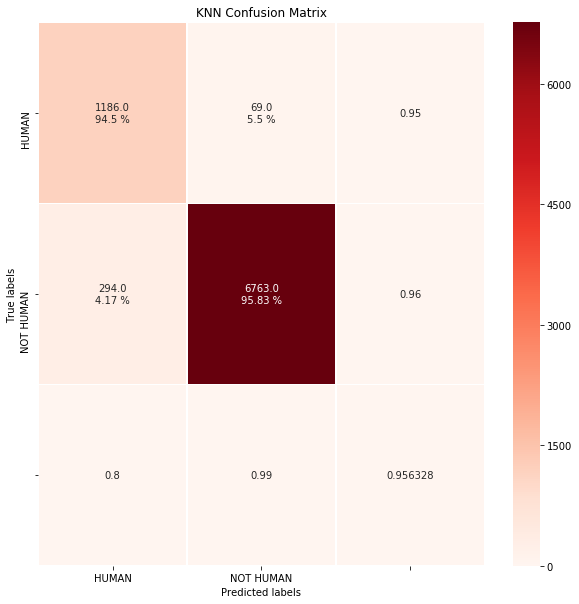

In [48]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(2,50), random_state=12)
clf.fit(normalized_X_Human_Non_Human_train, y_Human_Non_Human_train)
result = clf.predict(normalized_X_Human_Non_Human_test)
create_confusion_matrix(result, y_Human_Non_Human_test, ['HUMAN', 'NOT HUMAN'])